In [3]:
!pip install pvlib pandas numpy matplotlib seaborn scikit-learn statsmodels prophet xgboost requests -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [5]:
def fetch_nasa_power_data(latitude, longitude, start_date, end_date, location_name):
    """Fetch solar data from NASA POWER API"""
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    parameters = {
        'parameters': 'ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,PRECTOTCORR',
        'community': 'RE',
        'longitude': longitude,
        'latitude': latitude,
        'start': start_date.replace('-', ''),
        'end': end_date.replace('-', ''),
        'format': 'JSON'
    }
    
    print(f"\nFetching data for {location_name}...")
    response = requests.get(base_url, params=parameters)
    
    if response.status_code == 200:
        data = response.json()
        parameters_data = data['properties']['parameter']
        
        df = pd.DataFrame({
            'Date': pd.to_datetime(list(parameters_data['ALLSKY_SFC_SW_DWN'].keys()), format='%Y%m%d'),
            'Solar_Irradiance': list(parameters_data['ALLSKY_SFC_SW_DWN'].values()),
            'Temperature': list(parameters_data['T2M'].values()),
            'Humidity': list(parameters_data['RH2M'].values()),
            'Wind_Speed': list(parameters_data['WS2M'].values()),
            'Precipitation': list(parameters_data['PRECTOTCORR'].values())
        })
        
        df['Location'] = location_name
        print(f"✓ Data fetched: {len(df)} records")
        return df
    else:
        print(f"✗ Error: {response.status_code}")
        return None

print("✓ Function defined")

✓ Function defined


In [6]:
# Define location (Ghatkopar, Mumbai)
SELECTED_LOCATION = 'Ghatkopar'
latitude = 19.0860
longitude = 72.9081

# Date range (last 3 years)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=1095)).strftime('%Y-%m-%d')

# Fetch data
df = fetch_nasa_power_data(latitude, longitude, start_date, end_date, SELECTED_LOCATION)

# Save dataset
df.to_csv(f'solar_data_{SELECTED_LOCATION}.csv', index=False)
print(f"\n✓ Dataset saved as 'solar_data_{SELECTED_LOCATION}.csv'")
print(f"\nFirst 5 rows:\n{df.head()}")


Fetching data for Ghatkopar...
✓ Data fetched: 1095 records

✓ Dataset saved as 'solar_data_Ghatkopar.csv'

First 5 rows:
        Date  Solar_Irradiance  Temperature  Humidity  Wind_Speed  \
0 2022-10-25            5.9090        23.93     68.13        1.37   
1 2022-10-26            5.7737        23.73     71.45        1.72   
2 2022-10-27            5.3995        23.80     71.25        1.98   
3 2022-10-28            5.3206        23.39     71.09        2.25   
4 2022-10-29            5.5822        23.02     70.61        2.68   

   Precipitation   Location  
0            0.0  Ghatkopar  
1            0.0  Ghatkopar  
2            0.0  Ghatkopar  
3            0.0  Ghatkopar  
4            0.0  Ghatkopar  


In [7]:
print("=" * 50)
print("DATA PREPROCESSING")
print("=" * 50)

# Handle missing values
print(f"\nMissing values before:\n{df.isnull().sum()}")
df = df.fillna(method='ffill').fillna(method='bfill')

# Remove invalid values
df = df[df['Solar_Irradiance'] >= 0]

# Feature engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                   else 'Summer' if x in [3, 4, 5, 6] 
                                   else 'Monsoon' if x in [7, 8, 9] 
                                   else 'Post-Monsoon')

# Create lag features
for lag in [1, 7, 30]:
    df[f'Solar_Lag_{lag}'] = df['Solar_Irradiance'].shift(lag)

# Rolling statistics
df['Solar_Rolling_Mean_7'] = df['Solar_Irradiance'].rolling(window=7).mean()
df['Solar_Rolling_Std_7'] = df['Solar_Irradiance'].rolling(window=7).std()

df = df.dropna()

print(f"\nProcessed data shape: {df.shape}")
print(f"\nStatistics:\n{df[['Solar_Irradiance', 'Temperature', 'Humidity']].describe()}")

DATA PREPROCESSING

Missing values before:
Date                0
Solar_Irradiance    0
Temperature         0
Humidity            0
Wind_Speed          0
Precipitation       0
Location            0
dtype: int64

Processed data shape: (1060, 17)

Statistics:
       Solar_Irradiance  Temperature     Humidity
count       1060.000000  1060.000000  1060.000000
mean           4.965277    27.073538    68.495321
std            1.500933     2.919762    19.739292
min            0.305800    19.560000    17.610000
25%            4.104925    25.420000    53.507500
50%            5.008350    26.695000    70.215000
75%            6.108375    29.050000    88.250000
max            7.745300    36.440000    96.430000


EXPLORATORY DATA ANALYSIS


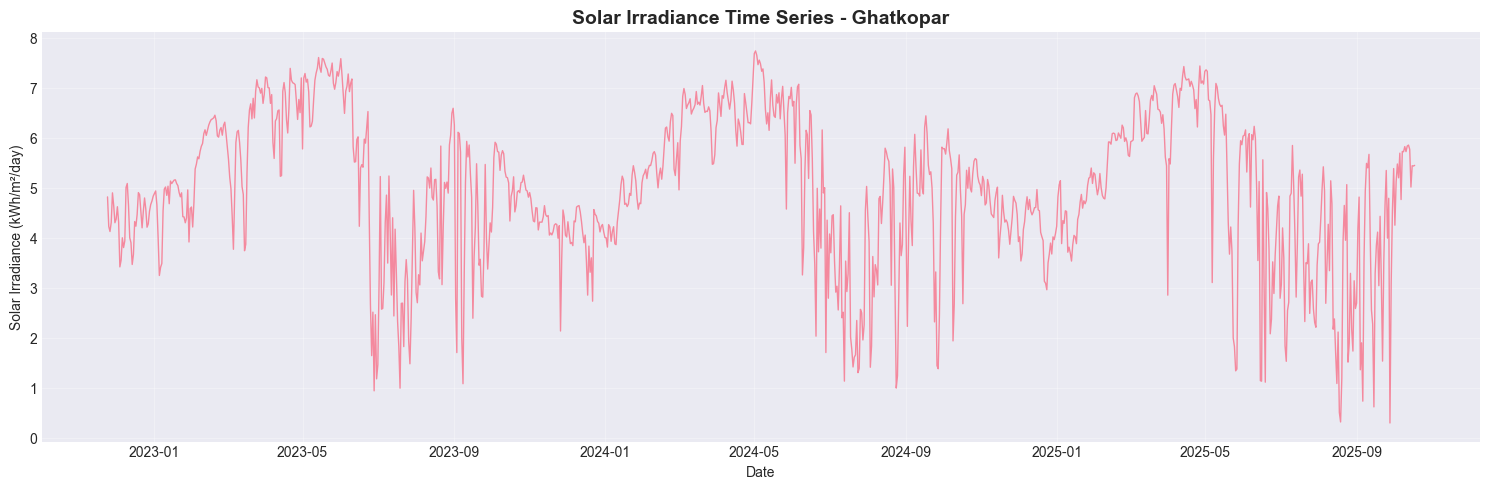

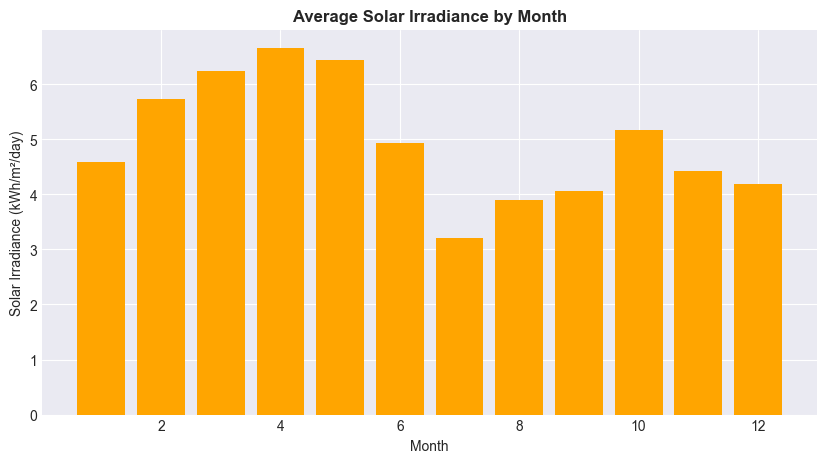

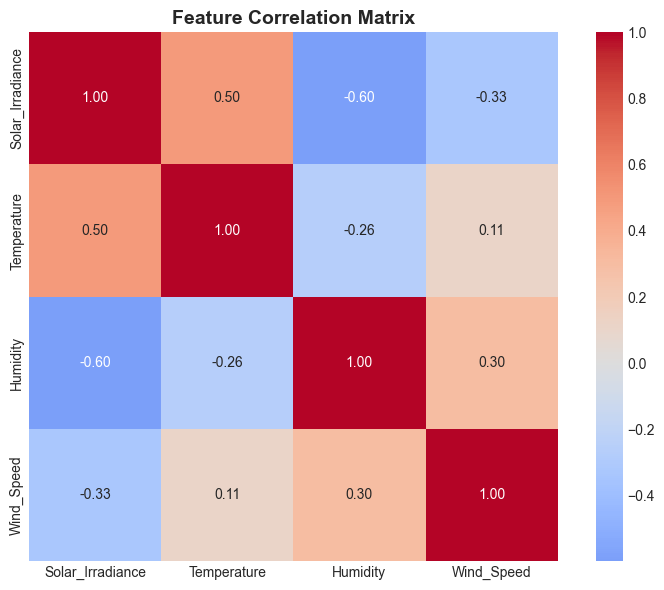

In [8]:
print("=" * 50)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Time series plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['Date'], df['Solar_Irradiance'], linewidth=1, alpha=0.8)
ax.set_title(f'Solar Irradiance Time Series - {SELECTED_LOCATION}', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Solar Irradiance (kWh/m²/day)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly average
monthly_avg = df.groupby('Month')['Solar_Irradiance'].mean()
plt.figure(figsize=(10, 5))
plt.bar(monthly_avg.index, monthly_avg.values, color='orange')
plt.title('Average Solar Irradiance by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Solar Irradiance (kWh/m²/day)')
plt.show()

# Correlation matrix
correlation_features = ['Solar_Irradiance', 'Temperature', 'Humidity', 'Wind_Speed']
corr_matrix = df[correlation_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
print("=" * 50)
print("MODEL TRAINING")
print("=" * 50)

# Prepare features
feature_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'Precipitation',
                'Month', 'DayOfYear', 'Solar_Lag_1', 'Solar_Lag_7', 
                'Solar_Rolling_Mean_7']

X = df[feature_cols]
y = df['Solar_Irradiance']

# Train-test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost (Best Model)
print("\nTraining XGBoost...")
xgb_model = XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, xgb_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
r2 = r2_score(y_test, xgb_pred)

print(f"\n✓ XGBoost Results:")
print(f"   MAE:  {mae:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   R²:   {r2:.4f}")

MODEL TRAINING
Training: 848 samples
Testing: 212 samples

Training XGBoost...

✓ XGBoost Results:
   MAE:  0.7272
   RMSE: 0.9483
   R²:   0.7374


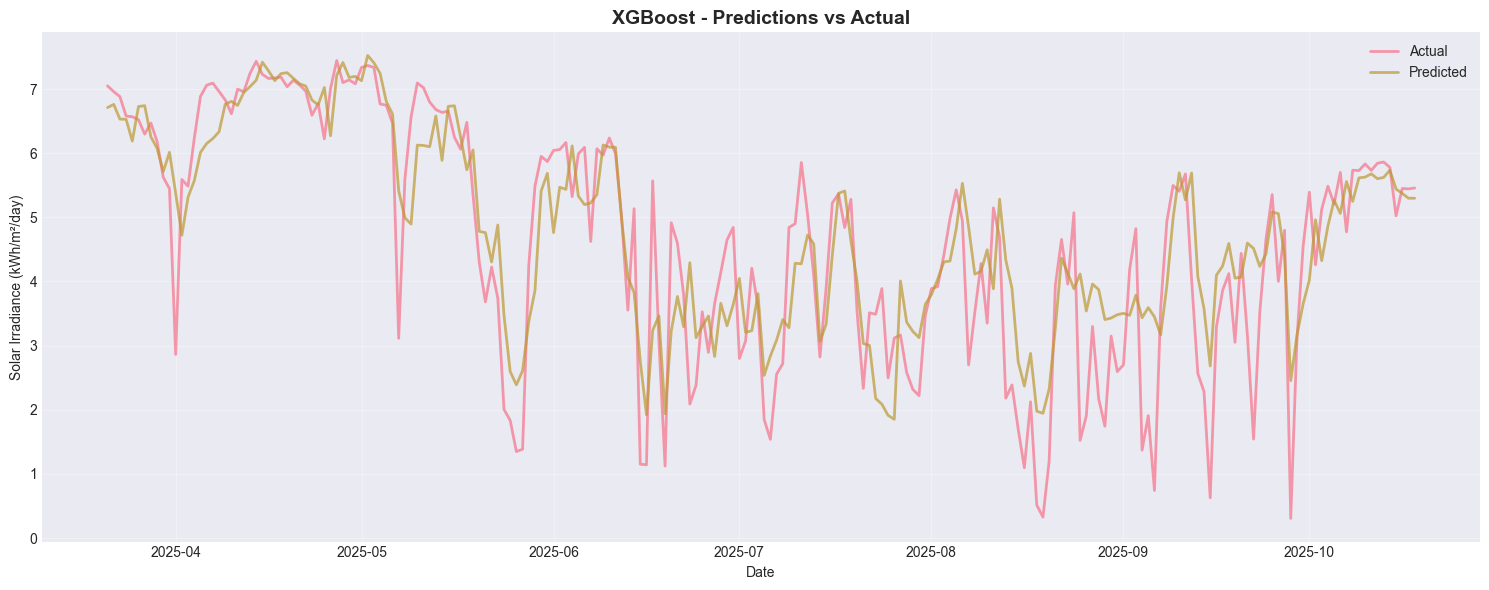

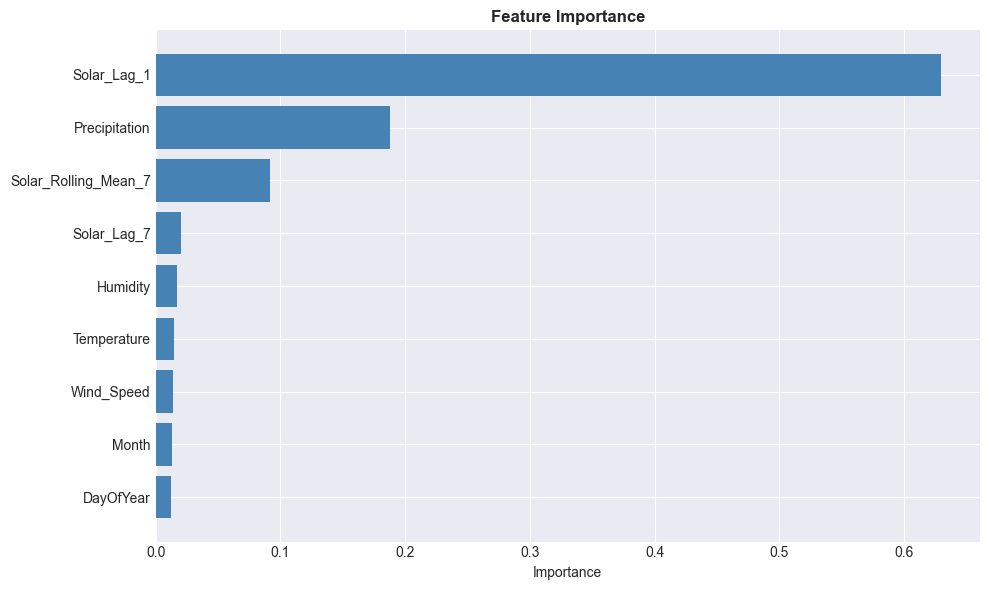

In [10]:
# Plot predictions
dates_test = df['Date'].iloc[split_idx:].values

plt.figure(figsize=(15, 6))
plt.plot(dates_test, y_test.values, label='Actual', linewidth=2, alpha=0.7)
plt.plot(dates_test, xgb_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.title('XGBoost - Predictions vs Actual', fontweight='bold', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Solar Irradiance (kWh/m²/day)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

FUTURE PREDICTIONS (30 Days)
        Date  Predicted_Solar_Irradiance
0 2025-10-19                    4.648761
1 2025-10-20                    4.648761
2 2025-10-21                    4.648761
3 2025-10-22                    4.648761
4 2025-10-23                    4.648761
5 2025-10-24                    4.648761
6 2025-10-25                    4.648761
7 2025-10-26                    4.670938
8 2025-10-27                    4.670938
9 2025-10-28                    4.670938


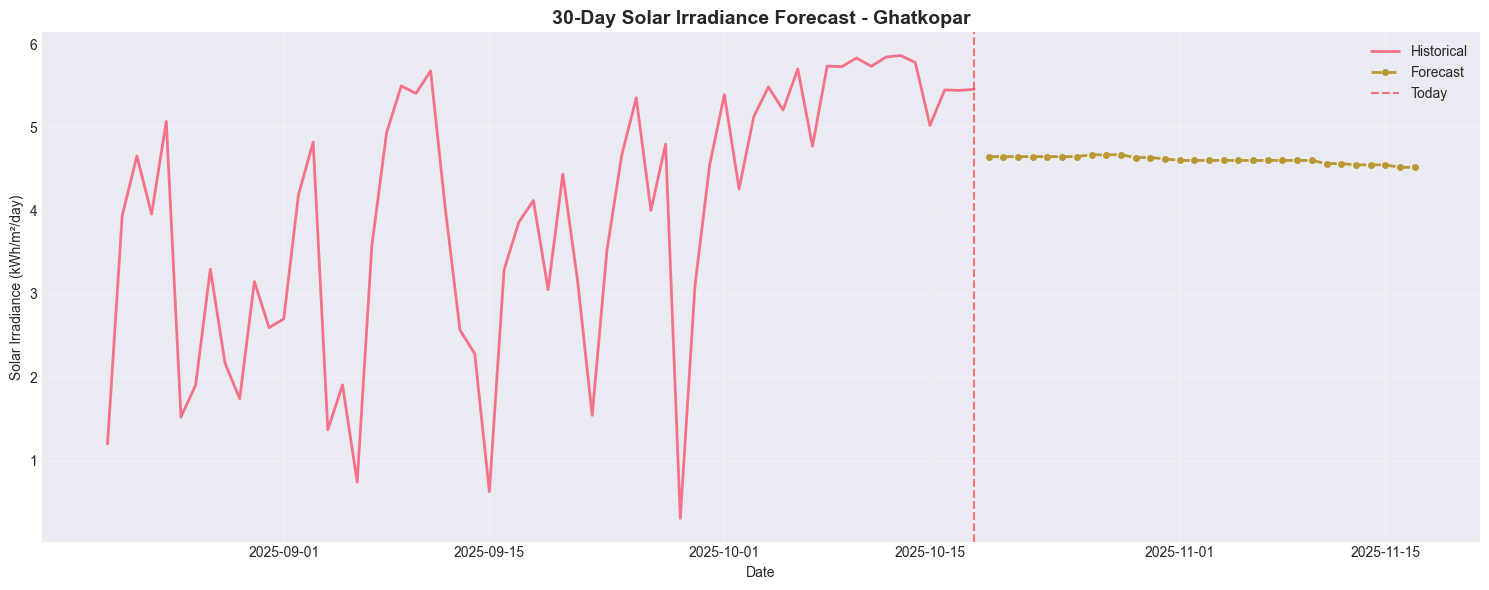


✓ Predictions saved to 'future_predictions.csv'


In [11]:
print("=" * 50)
print("FUTURE PREDICTIONS (30 Days)")
print("=" * 50)

# Create future dates
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

# Prepare future data
future_df = pd.DataFrame({
    'Date': future_dates,
    'Temperature': df['Temperature'].tail(30).mean(),
    'Humidity': df['Humidity'].tail(30).mean(),
    'Wind_Speed': df['Wind_Speed'].tail(30).mean(),
    'Precipitation': df['Precipitation'].tail(30).mean(),
    'Month': future_dates.month,
    'DayOfYear': future_dates.dayofyear,
    'Solar_Lag_1': df['Solar_Irradiance'].iloc[-1],
    'Solar_Lag_7': df['Solar_Irradiance'].iloc[-7],
    'Solar_Rolling_Mean_7': df['Solar_Irradiance'].tail(7).mean()
})

# Predict
future_X = future_df[feature_cols]
future_X_scaled = scaler.transform(future_X)
future_predictions = xgb_model.predict(future_X_scaled)

future_df['Predicted_Solar_Irradiance'] = future_predictions

# Display
print(future_df[['Date', 'Predicted_Solar_Irradiance']].head(10))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['Date'].tail(60), df['Solar_Irradiance'].tail(60), label='Historical', linewidth=2)
plt.plot(future_df['Date'], future_df['Predicted_Solar_Irradiance'], 
         label='Forecast', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.axvline(x=last_date, color='red', linestyle='--', alpha=0.5, label='Today')
plt.title(f'30-Day Solar Irradiance Forecast - {SELECTED_LOCATION}', fontweight='bold', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Solar Irradiance (kWh/m²/day)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save
future_df.to_csv('future_predictions.csv', index=False)
print("\n✓ Predictions saved to 'future_predictions.csv'")

In [13]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create visualizations folder
os.makedirs('visualizations', exist_ok=True)
print("✓ Visualizations folder created!")

# Load your data
df = pd.read_csv('solar_data_Ghatkopar.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Check what columns exist
print(f"\n📋 Columns in dataset: {list(df.columns)}")
print(f"✓ Data loaded: {len(df)} records")

# CREATE MISSING COLUMNS if they don't exist
if 'Month' not in df.columns:
    df['Month'] = df['Date'].dt.month
    print("✓ Created 'Month' column")

if 'Year' not in df.columns:
    df['Year'] = df['Date'].dt.year
    print("✓ Created 'Year' column")

if 'DayOfYear' not in df.columns:
    df['DayOfYear'] = df['Date'].dt.dayofyear
    print("✓ Created 'DayOfYear' column")

if 'Season' not in df.columns:
    df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                       else 'Summer' if x in [3, 4, 5, 6] 
                                       else 'Monsoon' if x in [7, 8, 9] 
                                       else 'Post-Monsoon')
    print("✓ Created 'Season' column")

if 'Solar_Lag_1' not in df.columns:
    df['Solar_Lag_1'] = df['Solar_Irradiance'].shift(1)
    print("✓ Created 'Solar_Lag_1' column")

if 'Solar_Lag_7' not in df.columns:
    df['Solar_Lag_7'] = df['Solar_Irradiance'].shift(7)
    print("✓ Created 'Solar_Lag_7' column")

if 'Solar_Rolling_Mean_7' not in df.columns:
    df['Solar_Rolling_Mean_7'] = df['Solar_Irradiance'].rolling(window=7).mean()
    print("✓ Created 'Solar_Rolling_Mean_7' column")

# Remove NaN rows created by lag features
df_clean = df.dropna()
print(f"\n✓ Cleaned data: {len(df_clean)} records")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Plot 1: Time Series
print("\n[1/8] Creating Time Series Plot...")
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_clean['Date'], df_clean['Solar_Irradiance'], linewidth=1, alpha=0.8, color='orange')
ax.set_title('Solar Irradiance Time Series - Ghatkopar, Mumbai', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Solar Irradiance (kWh/m²/day)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/1_time_series.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 1_time_series.png")

# Plot 2: Seasonal Analysis
print("\n[2/8] Creating Seasonal Analysis...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly average
monthly_avg = df_clean.groupby('Month')['Solar_Irradiance'].mean()
axes[0, 0].bar(monthly_avg.index, monthly_avg.values, color='orange')
axes[0, 0].set_title('Average Solar Irradiance by Month', fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Solar Irradiance (kWh/m²/day)')
axes[0, 0].set_xticks(range(1, 13))

# Seasonal average
seasonal_avg = df_clean.groupby('Season')['Solar_Irradiance'].mean()
axes[0, 1].bar(seasonal_avg.index, seasonal_avg.values, color='coral')
axes[0, 1].set_title('Average Solar Irradiance by Season', fontweight='bold')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Solar Irradiance (kWh/m²/day)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Distribution
axes[1, 0].hist(df_clean['Solar_Irradiance'], bins=50, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Distribution of Solar Irradiance', fontweight='bold')
axes[1, 0].set_xlabel('Solar Irradiance (kWh/m²/day)')
axes[1, 0].set_ylabel('Frequency')

# Temperature correlation
axes[1, 1].scatter(df_clean['Temperature'], df_clean['Solar_Irradiance'], alpha=0.5, s=10, color='green')
axes[1, 1].set_title('Solar Irradiance vs Temperature', fontweight='bold')
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Solar Irradiance (kWh/m²/day)')

plt.tight_layout()
plt.savefig('visualizations/2_seasonal_analysis.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 2_seasonal_analysis.png")

# Plot 3: Correlation Matrix
print("\n[3/8] Creating Correlation Matrix...")
correlation_features = ['Solar_Irradiance', 'Temperature', 'Humidity', 'Wind_Speed', 'Precipitation']
corr_matrix = df_clean[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/3_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 3_correlation_matrix.png")

# Plot 4: Year-over-Year Comparison
print("\n[4/8] Creating Year Comparison...")
fig, ax = plt.subplots(figsize=(15, 6))
colors = ['blue', 'green', 'red', 'purple']
for idx, year in enumerate(sorted(df_clean['Year'].unique())):
    year_data = df_clean[df_clean['Year'] == year]
    ax.plot(year_data['DayOfYear'], year_data['Solar_Irradiance'], 
            label=f'Year {year}', linewidth=2, alpha=0.7, color=colors[idx % len(colors)])
ax.set_title('Solar Irradiance - Year-over-Year Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Year', fontsize=12)
ax.set_ylabel('Solar Irradiance (kWh/m²/day)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/4_year_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 4_year_comparison.png")

# Plot 5: Box Plot by Season
print("\n[5/8] Creating Box Plot...")
fig, ax = plt.subplots(figsize=(12, 6))
season_order = ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
seasons_present = [s for s in season_order if s in df_clean['Season'].unique()]
df_clean.boxplot(column='Solar_Irradiance', by='Season', ax=ax, patch_artist=True)
ax.set_title('Solar Irradiance Distribution by Season', fontsize=14, fontweight='bold')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Solar Irradiance (kWh/m²/day)', fontsize=12)
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('visualizations/5_boxplot_season.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 5_boxplot_season.png")

# Plot 6: Monthly Heatmap
print("\n[6/8] Creating Monthly Heatmap...")
pivot_data = df_clean.pivot_table(values='Solar_Irradiance', 
                                   index='Month', 
                                   columns='Year', 
                                   aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Solar Irradiance (kWh/m²/day)'})
plt.title('Average Solar Irradiance by Month and Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.savefig('visualizations/6_monthly_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 6_monthly_heatmap.png")

# Plot 7: Statistical Summary
print("\n[7/8] Creating Statistical Summary Plot...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Monthly stats
monthly_stats = df_clean.groupby('Month')['Solar_Irradiance'].agg(['mean', 'min', 'max'])
x = monthly_stats.index
axes[0].plot(x, monthly_stats['mean'], marker='o', label='Mean', linewidth=2)
axes[0].fill_between(x, monthly_stats['min'], monthly_stats['max'], alpha=0.3, label='Min-Max Range')
axes[0].set_title('Monthly Solar Irradiance Statistics', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Solar Irradiance (kWh/m²/day)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 13))

# Cumulative distribution
sorted_solar = np.sort(df_clean['Solar_Irradiance'])
cumulative = np.arange(1, len(sorted_solar) + 1) / len(sorted_solar) * 100
axes[1].plot(sorted_solar, cumulative, linewidth=2, color='purple')
axes[1].set_title('Cumulative Distribution of Solar Irradiance', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Solar Irradiance (kWh/m²/day)')
axes[1].set_ylabel('Cumulative Percentage (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/7_statistical_summary.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 7_statistical_summary.png")

# Plot 8: Data Quality Overview
print("\n[8/8] Creating Data Quality Overview...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Data availability by month
data_counts = df_clean.groupby('Month').size()
axes[0, 0].bar(data_counts.index, data_counts.values, color='steelblue')
axes[0, 0].set_title('Data Availability by Month', fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].set_xticks(range(1, 13))

# Temperature distribution
axes[0, 1].hist(df_clean['Temperature'], bins=30, color='salmon', edgecolor='black')
axes[0, 1].set_title('Temperature Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Frequency')

# Humidity distribution
axes[1, 0].hist(df_clean['Humidity'], bins=30, color='lightblue', edgecolor='black')
axes[1, 0].set_title('Humidity Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Humidity (%)')
axes[1, 0].set_ylabel('Frequency')

# Wind Speed distribution
axes[1, 1].hist(df_clean['Wind_Speed'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Wind Speed Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Wind Speed (m/s)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('visualizations/8_data_overview.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 8_data_overview.png")

# Save the updated dataset with new columns
df_clean.to_csv('solar_data_Ghatkopar_processed.csv', index=False)

print("\n" + "="*60)
print("✅ ALL VISUALIZATIONS CREATED SUCCESSFULLY!")
print("="*60)
print(f"\n📁 Location: C:\\Users\\adity\\OneDrive\\Desktop\\SolarProject\\visualizations\\")
print("\n📊 Files created (8 plots):")
print("   1. 1_time_series.png - Time series plot")
print("   2. 2_seasonal_analysis.png - Seasonal patterns")
print("   3. 3_correlation_matrix.png - Feature correlations")
print("   4. 4_year_comparison.png - Year-over-year trends")
print("   5. 5_boxplot_season.png - Seasonal distribution")
print("   6. 6_monthly_heatmap.png - Monthly heatmap")
print("   7. 7_statistical_summary.png - Statistical analysis")
print("   8. 8_data_overview.png - Data quality overview")
print("\n📄 Bonus: Updated dataset saved as 'solar_data_Ghatkopar_processed.csv'")
print("\n✨ All files ready for your report!")

✓ Visualizations folder created!

📋 Columns in dataset: ['Date', 'Solar_Irradiance', 'Temperature', 'Humidity', 'Wind_Speed', 'Precipitation', 'Location']
✓ Data loaded: 1095 records
✓ Created 'Month' column
✓ Created 'Year' column
✓ Created 'DayOfYear' column
✓ Created 'Season' column
✓ Created 'Solar_Lag_1' column
✓ Created 'Solar_Lag_7' column
✓ Created 'Solar_Rolling_Mean_7' column

✓ Cleaned data: 1088 records

📊 CREATING VISUALIZATIONS

[1/8] Creating Time Series Plot...
✓ Saved: 1_time_series.png

[2/8] Creating Seasonal Analysis...
✓ Saved: 2_seasonal_analysis.png

[3/8] Creating Correlation Matrix...
✓ Saved: 3_correlation_matrix.png

[4/8] Creating Year Comparison...
✓ Saved: 4_year_comparison.png

[5/8] Creating Box Plot...
✓ Saved: 5_boxplot_season.png

[6/8] Creating Monthly Heatmap...
✓ Saved: 6_monthly_heatmap.png

[7/8] Creating Statistical Summary Plot...
✓ Saved: 7_statistical_summary.png

[8/8] Creating Data Quality Overview...
✓ Saved: 8_data_overview.png

✅ ALL VIS

In [14]:
print("="*70)
print("🤖 TRAINING AND COMPARING 4 DIFFERENT MODELS")
print("="*70)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('solar_data_Ghatkopar.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create features if not present
if 'Month' not in df.columns:
    df['Month'] = df['Date'].dt.month
if 'DayOfYear' not in df.columns:
    df['DayOfYear'] = df['Date'].dt.dayofyear
if 'Solar_Lag_1' not in df.columns:
    df['Solar_Lag_1'] = df['Solar_Irradiance'].shift(1)
if 'Solar_Lag_7' not in df.columns:
    df['Solar_Lag_7'] = df['Solar_Irradiance'].shift(7)
if 'Solar_Rolling_Mean_7' not in df.columns:
    df['Solar_Rolling_Mean_7'] = df['Solar_Irradiance'].rolling(7).mean()

df = df.dropna()

# Prepare features
feature_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'Precipitation',
                'Month', 'DayOfYear', 'Solar_Lag_1', 'Solar_Lag_7', 
                'Solar_Rolling_Mean_7']

X = df[feature_cols]
y = df['Solar_Irradiance']

# Train-test split (80-20)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = df['Date'].iloc[split_idx:].values

print(f"\n📊 Data Split:")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples:  {len(X_test)}")

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = {}

# ==================== MODEL 1: ARIMA ====================
print("\n" + "="*70)
print("[1/4] Training ARIMA Model...")
print("="*70)
try:
    arima_model = ARIMA(y_train, order=(5, 1, 2))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=len(y_test))
    
    results['ARIMA'] = {
        'predictions': arima_pred.values,
        'mae': mean_absolute_error(y_test, arima_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, arima_pred)),
        'r2': r2_score(y_test, arima_pred)
    }
    print(f"✓ ARIMA Complete!")
    print(f"   MAE:  {results['ARIMA']['mae']:.4f}")
    print(f"   RMSE: {results['ARIMA']['rmse']:.4f}")
    print(f"   R²:   {results['ARIMA']['r2']:.4f}")
except Exception as e:
    print(f"✗ ARIMA failed: {e}")
    results['ARIMA'] = None

# ==================== MODEL 2: RANDOM FOREST ====================
print("\n" + "="*70)
print("[2/4] Training Random Forest Model...")
print("="*70)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

results['Random Forest'] = {
    'predictions': rf_pred,
    'mae': mean_absolute_error(y_test, rf_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, rf_pred)),
    'r2': r2_score(y_test, rf_pred)
}
print(f"✓ Random Forest Complete!")
print(f"   MAE:  {results['Random Forest']['mae']:.4f}")
print(f"   RMSE: {results['Random Forest']['rmse']:.4f}")
print(f"   R²:   {results['Random Forest']['r2']:.4f}")

# ==================== MODEL 3: XGBOOST ====================
print("\n" + "="*70)
print("[3/4] Training XGBoost Model...")
print("="*70)
xgb_model = XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, 
                         random_state=42, verbosity=0)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

results['XGBoost'] = {
    'predictions': xgb_pred,
    'mae': mean_absolute_error(y_test, xgb_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, xgb_pred)),
    'r2': r2_score(y_test, xgb_pred)
}
print(f"✓ XGBoost Complete!")
print(f"   MAE:  {results['XGBoost']['mae']:.4f}")
print(f"   RMSE: {results['XGBoost']['rmse']:.4f}")
print(f"   R²:   {results['XGBoost']['r2']:.4f}")

# ==================== MODEL 4: PROPHET ====================
print("\n" + "="*70)
print("[4/4] Training Prophet Model...")
print("="*70)
try:
    prophet_df = df[['Date', 'Solar_Irradiance']].rename(
        columns={'Date': 'ds', 'Solar_Irradiance': 'y'}
    )
    prophet_df_train = prophet_df[:split_idx]
    
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, 
                           daily_seasonality=False, seasonality_mode='multiplicative')
    prophet_model.fit(prophet_df_train)
    
    future_dates = prophet_model.make_future_dataframe(periods=len(y_test))
    prophet_forecast = prophet_model.predict(future_dates)
    prophet_pred = prophet_forecast['yhat'].iloc[-len(y_test):].values
    
    results['Prophet'] = {
        'predictions': prophet_pred,
        'mae': mean_absolute_error(y_test, prophet_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, prophet_pred)),
        'r2': r2_score(y_test, prophet_pred)
    }
    print(f"✓ Prophet Complete!")
    print(f"   MAE:  {results['Prophet']['mae']:.4f}")
    print(f"   RMSE: {results['Prophet']['rmse']:.4f}")
    print(f"   R²:   {results['Prophet']['r2']:.4f}")
except Exception as e:
    print(f"✗ Prophet failed: {e}")
    print("   (Prophet requires 'prophet' package: pip install prophet)")
    results['Prophet'] = None

# ==================== MODEL COMPARISON ====================
print("\n" + "="*70)
print("📊 MODEL COMPARISON RESULTS")
print("="*70)

# Create comparison table
comparison_data = []
for model_name in ['ARIMA', 'Random Forest', 'XGBoost', 'Prophet']:
    if results[model_name] is not None:
        comparison_data.append({
            'Model': model_name,
            'MAE': results[model_name]['mae'],
            'RMSE': results[model_name]['rmse'],
            'R² Score': results[model_name]['r2']
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['MAE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   (Based on lowest MAE)")

# Save comparison
comparison_df.to_csv('model_comparison_results.csv', index=False)
print(f"\n✓ Results saved to 'model_comparison_results.csv'")

# ==================== VISUALIZATIONS ====================
print("\n" + "="*70)
print("📊 CREATING MODEL COMPARISON VISUALIZATIONS")
print("="*70)

import os
os.makedirs('visualizations', exist_ok=True)

# Plot 1: Model Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE Comparison
axes[0].bar(comparison_df['Model'], comparison_df['MAE'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_title('Mean Absolute Error (MAE) Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('MAE (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE Comparison
axes[1].bar(comparison_df['Model'], comparison_df['RMSE'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_title('Root Mean Squared Error (RMSE) Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylabel('RMSE (Lower is Better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# R² Score Comparison
axes[2].bar(comparison_df['Model'], comparison_df['R² Score'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[2].set_title('R² Score Comparison', fontweight='bold', fontsize=14)
axes[2].set_ylabel('R² Score (Higher is Better)')
axes[2].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Good Threshold')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: visualizations/model_comparison_metrics.png")

# Plot 2: All Model Predictions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, model_results) in enumerate(results.items()):
    if model_results is not None:
        ax = axes[idx]
        
        # Plot actual vs predicted
        ax.plot(dates_test, y_test.values, label='Actual', linewidth=2, alpha=0.7, color='blue')
        ax.plot(dates_test, model_results['predictions'], label='Predicted', 
                linewidth=2, alpha=0.7, color='red', linestyle='--')
        
        ax.set_title(f'{model_name} Predictions', fontweight='bold', fontsize=12)
        ax.set_xlabel('Date')
        ax.set_ylabel('Solar Irradiance (kWh/m²/day)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add metrics box
        metrics_text = f"MAE: {model_results['mae']:.3f}\nR²: {model_results['r2']:.3f}"
        ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('visualizations/all_model_predictions.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: visualizations/all_model_predictions.png")

# Plot 3: Feature Importance (for tree-based models)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest - Feature Importance', fontweight='bold', fontsize=14)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='coral')
axes[1].set_xlabel('Importance Score')
axes[1].set_title('XGBoost - Feature Importance', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('visualizations/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: visualizations/feature_importance_comparison.png")

print("\n" + "="*70)
print("✅ MODEL TRAINING AND COMPARISON COMPLETE!")
print("="*70)
print(f"\n📁 Files Created:")
print(f"   1. model_comparison_results.csv")
print(f"   2. visualizations/model_comparison_metrics.png")
print(f"   3. visualizations/all_model_predictions.png")
print(f"   4. visualizations/feature_importance_comparison.png")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   MAE: {comparison_df.loc[best_model_idx, 'MAE']:.4f}")
print(f"   R²: {comparison_df.loc[best_model_idx, 'R² Score']:.4f}")

🤖 TRAINING AND COMPARING 4 DIFFERENT MODELS

📊 Data Split:
   Training samples: 870
   Testing samples:  218

[1/4] Training ARIMA Model...
✓ ARIMA Complete!
   MAE:  25.0417
   RMSE: 152.2930
   R²:   -0.0273

[2/4] Training Random Forest Model...
✓ Random Forest Complete!
   MAE:  23.6433
   RMSE: 151.8524
   R²:   -0.0214

[3/4] Training XGBoost Model...
✓ XGBoost Complete!
   MAE:  23.7254
   RMSE: 151.9557
   R²:   -0.0228

[4/4] Training Prophet Model...


00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet Complete!
   MAE:  24.1756
   RMSE: 152.0723
   R²:   -0.0243

📊 MODEL COMPARISON RESULTS

        Model       MAE       RMSE  R² Score
        ARIMA 25.041654 152.292962 -0.027321
Random Forest 23.643269 151.852427 -0.021386
      XGBoost 23.725445 151.955652 -0.022775
      Prophet 24.175643 152.072288 -0.024346

🏆 BEST MODEL: Random Forest
   (Based on lowest MAE)

✓ Results saved to 'model_comparison_results.csv'

📊 CREATING MODEL COMPARISON VISUALIZATIONS
✓ Saved: visualizations/model_comparison_metrics.png
✓ Saved: visualizations/all_model_predictions.png
✓ Saved: visualizations/feature_importance_comparison.png

✅ MODEL TRAINING AND COMPARISON COMPLETE!

📁 Files Created:
   1. model_comparison_results.csv
   2. visualizations/model_comparison_metrics.png
   3. visualizations/all_model_predictions.png
   4. visualizations/feature_importance_comparison.png

🏆 Best Model: Random Forest
   MAE: 23.6433
   R²: -0.0214
